## Experiment 1: Learning Basic Geostrophy with CNN

In [1]:
import xarray as xr
import numpy as np

In [2]:
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
from torch import nn
import torch

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import os

In [5]:
import matplotlib.pyplot as plt

In [6]:
import gsw

### Useful Function

In [7]:
def scale_data(data,stype='minmax',datatype='scalar',refData='self'):
    if (refData == 'self'): refData = data
    
    if datatype == 'vector':
        vmax = refData.max()
        vmin = -1*refData.max()
    else:
        vmax = refData.max()
        vmin = refData.min()
    print(vmax,vmin)    
    if stype == 'minmax':
        to_subtract = vmin
        to_divide = (vmax - vmin)
    elif stype == 'robust':
        to_subtract = np.median(refData)
        to_divide = (np.percentile(refData,0.75) - np.percentile(refData,0.25))
    elif stype == 'standard':
        to_subtract = refData.mean()
        to_divide = refData.std()
    data = (data - to_subtract)/to_divide
    return data, to_subtract, to_divide

In [8]:
def dropnan(data):
    samples_n = data.shape[0]
    nansample_idx = [i for i in np.arange(samples_n) if np.sum(np.isnan(data[i])) > 0]
    data = np.delete(data,nansample_idx,axis=0)
    return data

In [9]:
class MetricTracker(pl.Callback):

    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    def on_validation_batch_end(self,trainer, module, outputs, *params):
        pass
            
    def on_validation_epoch_end(self,trainer, module):
        if 'train_loss' in trainer.callback_metrics:
            last_train_loss = trainer.callback_metrics['train_loss'].cpu().numpy()
            self.train_loss.append(last_train_loss)
        if 'val_loss' in trainer.callback_metrics:
            last_val_loss = trainer.callback_metrics['val_loss'].cpu().numpy()
            self.val_loss.append(last_val_loss)


In [10]:
from scipy.stats import linregress

def plot_scatter_correlation(x,y,ax=False):
    if not ax:
        fig = plt.figure(figsize=[5,3])
        ax = plt.subplot2grid((1, 1), (0, 0))
        
    lr = linregress(x,y)
    ax.scatter(x,y,marker='+')
    
    linear_y = lr.slope*x+lr.intercept
    ax.plot(x,linear_y,color='red',label='Correlation {0}'.format(np.round(lr.rvalue,2)))
    ax.legend()
    return ax

### CNN Model

In [11]:
torch.abs

<function _VariableFunctionsClass.abs>

In [12]:
class geostrophyModel(pl.LightningModule):
    def __init__(self,depthsN=20,learning_rate=0.001):
        super().__init__()
        self.lr = learning_rate
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=2,kernel_size=1,
                                     padding_mode='reflect', padding='same')
        self.relu1 = torch.nn.ReLU()
       
    
        #self.conv2 = torch.nn.Conv2d(in_channels=50, out_channels=30,kernel_size=1,
        #                             padding_mode='reflect', padding='same')
        #self.relu2 = torch.nn.ReLU()
        
        
        #self.conv3 = torch.nn.Conv2d(in_channels=30, out_channels=2,kernel_size=1,
        #                             padding_mode='reflect', padding='same')        
        #self.loss = torch.nn.MSELoss()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        
        #x = self.conv2(x)
        #x = self.relu2(x)
        
        #x = self.conv3(x)
        return x
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def compute_loss(self,pred,true):
        return torch.mean(((true-pred))**2/torch.std(true)**2)
        #cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        #pearson = cos(x1 - x1.mean(), x2 - x2.mean())
        #return pearson
    
    def training_step(self, batch, batch_idx):
        ssh = torch.unsqueeze(batch[:,0].float(),1)
        vgeo_true = batch[:,1:3].float()
        vgeo_pred  = self.forward(ssh)                
        loss = self.compute_loss(vgeo_pred, vgeo_true)
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        ssh = torch.unsqueeze(batch[:,0].float(),1)
        vgeo_true = batch[:,1:3].float()
        vgeo_pred  = self.forward(ssh)
        loss = self.compute_loss(vgeo_pred, vgeo_true)
        self.log('val_loss', loss)
        return loss

### Geostrophy Velocities Data Module

In [13]:
class eNATL60DataModule(pl.LightningDataModule):
    def __init__(self, ds, lon=None, lat=None, depthN=10,n=365):
        self.ds = ds.isel(time_counter=slice(0,n))
        self.lat = lat
        self.lon = lon
        self.depthN = depthN
        self.n = n
        super().__init__()
    
    def prepare_geostrophic_data(self):
        self.data = np.zeros((3,)+self.ds['ssh'].shape)
        
        self.data[0] = self.ds['ssh'].values
        #self.data[0], *self.ssh_sparam = scale_data(self.data[0])

        self.data[1] = -1*np.gradient(self.data[0],axis=1)
        self.data[2] = np.gradient(self.data[0],axis=2)
        
        self.data[0] = minmax_scaler(self.data[1])
        self.data[1] = minmax_scaler(self.data[1])
        self.data[2] = minmax_scaler(self.data[2])
        #vm = np.sqrt(self.data[0]**2+self.data[1]**2)
        #self.data[1], *self.v_sparam = scale_data(self.data[1],
        #                                          refData=vm,datatype='vector')
        #self.data[2], *self.v_sparam = scale_data(self.data[2],
        #                                          refData=vm,datatype='vector')
        
        self.data = dropnan(self.data)
        
        self.data = np.swapaxes(MEDBAL_dl.data,0,1)
        print(self.data.shape)
                        
    def setup(self,val_pct=0.3,test_pct=0.1,batch_size=64):
        self.batch_size = batch_size
        
        split_idx = (np.cumsum([0,val_pct,test_pct])*self.n).astype(int)

        self.val_split = self.data[0:split_idx[1]]
        self.test_split = self.data[split_idx[1]:split_idx[2]]
        self.train_split = self.data[split_idx[2]:]
    
    def train_dataloader(self):
        return DataLoader(self.train_split, 
                          batch_size=self.batch_size, 
                          shuffle=False,num_workers=10)
    
    def val_dataloader(self):
        return DataLoader(self.val_split, 
                          batch_size=self.batch_size, 
                          shuffle=False,num_workers=10)
    
    def test_dataloader(self):
        return DataLoader(self.test_split, 
                          batch_size=self.batch_size, 
                          shuffle=False,num_workers=10)

### Parameters definition and data loading

In [14]:
dd = '/home/ecutolo/Data/MEDBAL/'
lat = (39.95,40.95)
lon = (1.05,2.95)
depthN = 20

learning_rate = 0.01

In [15]:
MEDBAL_dl = eNATL60DataModule(xr.open_dataset(dd+'MEDBAL.nc'),
                              lon=lon,lat=lat,n=365,depthN=depthN)

In [16]:
def minmax_scaler(v):
    return (v-v.min())/(v.max()-v.min())

In [17]:
MEDBAL_dl.prepare_geostrophic_data()

(365, 3, 76, 104)


In [18]:
v = MEDBAL_dl.data[:,1]

In [19]:
np.min(v)

0.0

In [20]:
MEDBAL_dl.setup(batch_size=32)

### Model Training

In [21]:
model = geostrophyModel(learning_rate=learning_rate)

In [22]:
cb = MetricTracker()

In [23]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=300, 
    callbacks=[cb,
        EarlyStopping(monitor="val_loss", patience=15),
        ModelCheckpoint(monitor='val_loss',
                        dirpath='.', 
                        filename='model',
                        save_weights_only=True)]
)

history = trainer.fit(model, MEDBAL_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/ecutolo/mambaforge/envs/ML/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 4     
1 | relu1 | ReLU   | 0     
---------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)
/home/ecutolo/mambaforge/envs/ML/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ecutolo/Workdir/oceanix-course exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists a

Validation sanity check: 0it [00:00, ?it/s]

/home/ecutolo/mambaforge/envs/ML/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:394: UserWarning: The number of training samples (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Test

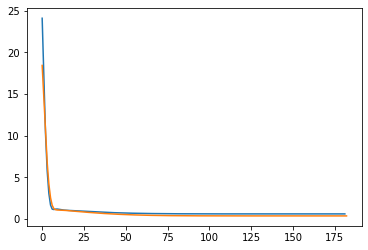

In [31]:
plt.plot(np.array(cb.train_loss))
plt.plot(np.array(cb.val_loss))

In [32]:
test_snapshot = next(iter(MEDBAL_dl.train_dataloader()))[0]
test_ssh = torch.unsqueeze(torch.unsqueeze(test_snapshot[0],0),0)
test_vgeo = test_snapshot[1:3]

In [33]:
test_vgeo_pred = model.forward(test_ssh.float()).detach().numpy()[0]

<AxesSubplot:>

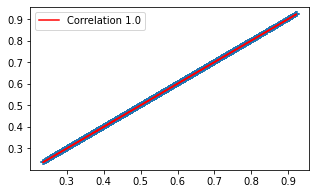

In [34]:
plot_scatter_correlation(test_vgeo_pred[0].ravel(),test_vgeo[0].ravel())

In [35]:
test_snapshot = next(iter(MEDBAL_dl.train_dataloader()))[10]

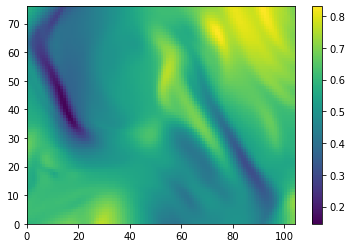

In [36]:
plt.pcolormesh(test_vgeo[1])
plt.colorbar()

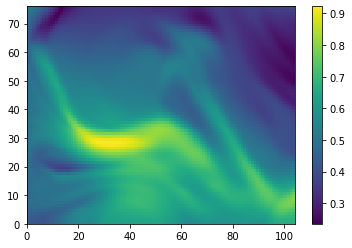

In [37]:
plt.pcolormesh(test_vgeo_pred[0])
plt.colorbar()